<a href="https://colab.research.google.com/github/kumgleb/McKinsey_prohack_2020/blob/master/Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports:

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
np.random.seed(42)



---



# Optimisation:

In the first part, target feature index $I$, also known as well-being index, was predicted. According to the task, there is a potential for increase in well-being index defined as:
\begin{equation}
P=-log(I+0.001)+3
\end{equation}

Then the likelihood of increase in index depends on allocated energy $E$ and potential as:
\begin{equation}
L=EP^2/1000
\end{equation}

And there are also few constraints:
1. Total resource available for allocation $E_{total}=50000$
2. For every galaxy 0-100 points of resource should be allocated. 
3. For galaxies with `existance expectancy index` < 0.7 at least 10% of total energy should be allocated. 

So the goal is to allocate energy $E$ in a way to maximize overall potential of index growth. Task can be formalized as follows:
\begin{equation}
\sum\limits_{i=1}^{N}{L_i(P(I_i), E_i)} \rightarrow \max\limits_{E_i}
\end{equation}

\begin{equation}
\sum\limits_{i=1}^{N}{E_i} \le E_{total}
\end{equation}

\begin{equation}
0 \le E_i \le 100, \space \forall i \in[0, N]
\end{equation}

\begin{equation}
\sum\limits_{i=1}^{N}{(E_i|eei < 0.7)} \ge 0.1E_{total}
\end{equation}

Objective can be represented as a dot product between defined $P^2$ and $E$. To maximize it, one should set maximum energy as $E_{max}$ for $k$ with biggest $P_i$ and $0$ for the rest, where $k=E_{total}/E_{max}$. . <br> 
The problem is that $P$ is calculated based on a predicted value $I$, thus such maximisation can lead to a significant error if there are mistakes in $I$. Let's consider the following example: <br>
* Suppose we had 5 galaxies and $E_{max}=100$ and $E_{total}=300$<br>
* Let estimation of potential for index increase be $P_{estimated}^2=[0.65, 0.7, 0.9, 0.9, 0.85]$, to maximise objective we should allocate $E_{max}$ for the $3$ highest values of $P$, so $E_{estimated}=[0, 0, 100, 100, 100]$ and objective $P^2\cdot E=265$.
* Now let true potential be $P_{true}^2=[0.65, 0.8, 0.9, 0.95, 0.75]$ , thus an optimal allocation should be $E_{true}=[0, 100, 100, 100, 0]$.
* So if we allocate energy based on $P_{estimated}$, the final objectibe $P_{true}^2 \cdot E_{estimated}$ will be equal 260, less than possible maximum.


In order to deal with uncertanty in $P$ I treat this problem probabilistically with the following strategy: <br>
* Assume that true distribution of $P_{true}$ can be represented as $P_{predicted}$ with some Gaussian noise $\xi \sim \mathcal{N}(\mu, \sigma)$:
\begin{equation}
P_{predicted}=P_{true}+\xi, \space \xi \sim \mathcal{N}(\mu, \sigma)
\end{equation}
* We can estimate $\mathcal{N}(\mu, \sigma)$ by difference between predicted and true values for the train set with known target.
* Then we can perform a simulation and generate different samples of $P$, supposing that $P_{true}=P_{predicted}-\xi$
* For every iteration for sample $P_i$ we can assign $1$ for top $k$ values and $0$ for the rest, let's call it allocation index ($ai_i$)
* After $M$ iterations we can obtain mean allocation index ($mai_i$) for every $i'th$ galaxy as:
\begin{equation}
mai_i=\frac{1}{M} \sum\limits_{j=1}^{M}ai^i_j
\end{equation} 
* Finally, let's allocate energy with respect to $mai_i$.

Thus $mai_i$ represents level of confidence for maximum allocation: 
* If $P_i$ is big enough, then $mai_i \rightarrow 1$ and we can confidently allocate $E_{max}$ for $i'th$ galaxy
* If $mai_i < 1$, then we diversify allocation and give to it less than $E_{max}$.

Now let's implement it. First I estimate noise distribution parameters $\mu , \sigma$ for $\xi \sim \mathcal{N}(\mu , \sigma)$:

In [ ]:
train_meta = pd.read_csv('/Predictions/predictions_meta.csv')
test_meta = pd.read_csv('/Predictions/predictions_test_meta.csv')

test = pd.read_csv('/Data/test.csv')

In [ ]:
a = 0.63
pred = a * train_meta['prd_1'] + (1 - a) * train_meta['prd_2']

P_est = (-np.log(pred + 0.001) + 3)**2 
P_true = (-np.log(train_meta.y + 0.001) + 3)**2 

deviations = P_true - P_est

mu_dev = deviations.mean()
std_dev = deviations.std()

print('Estimated error distribution parameters:')
print(f' mu: {mu_dev:.4f}')
print(f' sigma: {std_dev:.4f}')

Estimated error distribution parameters:
 mu: 0.1594
 sigma: 1.3945


In [ ]:
E_total = 50000
E_max = 100
k = E_total/E_max

test_meta['mai'] = 0
test_meta['P_est'] = (-np.log(test_meta['final_prediciton'] + 0.001) + 3)**2 

n_iters = 1000
N = test_meta.shape[0]
for i in range(1, n_iters+1):
  noise = np.random.normal(mu_dev, std_dev, size=(N,))
  test_meta['ai'] = 0
  test_meta['P_est_noise'] = test_meta['P_est'] - noise
  test_meta = test_meta.sort_values(by='P_est_noise') 
  test_meta.loc[k:, 'ai'] = 1

  # updating mean value on every iteration
  test_meta['mai'] = (test_meta['mai']*(i - 1) + test_meta['ai']) / i 

Text(0.5, 1.0, 'potential vs mai')

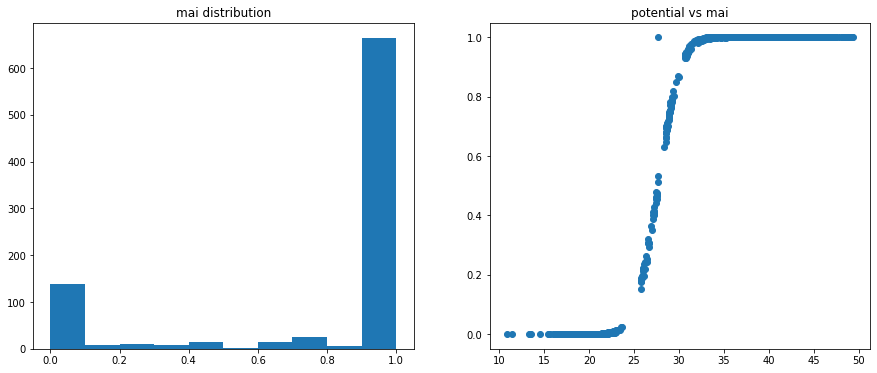

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].hist(test_meta['mai'])
ax[1].scatter(test_meta['P_est'], test_meta['mai'])

ax[0].set_title('mai distribution')
ax[1].set_title('potential vs mai')

It turned out that we can confidently allocate maximum energy for more than 500 galaxies, that means that if there are more than 450 galaxies with `existance expectance index` >= 0.7 and more than 50 galaxies with `existance expectance index` < 0.7 than we can just allocate $E_{max}$, for top 50 galaxies with low `existance expectance index` and for top 450 for galaxies with high `existance expectance index`.

In [ ]:
test_meta = pd.merge(test_meta, test[['galaxy', 'galactic year', 'existence expectancy index']],
                                     on=['galaxy', 'galactic year'], how='left')

In [ ]:
n_low_eei = test_meta[(test_meta['mai'] == 1.) & (test_meta['existence expectancy index'] < 0.7)].shape[0]
n_high_eei = test_meta[(test_meta['mai'] == 1.) & (test_meta['existence expectancy index'] >= 0.7)].shape[0]

print(f'There are {n_low_eei} galaxies with low index and `mai`== 1.')
print(f'There are {n_high_eei} galaxies with high index and `mai`== 1.')

There are 65 galaxies with low index and `mai`== 1.
There are 505 galaxies with high index and `mai`== 1.


So we can allocate $E_{max}$ for top 50 `mai` with low `existence expectancy index`:

In [ ]:
test_meta_low_eei = test_meta[test_meta['existence expectancy index'] < 0.7].copy()
n = test_meta_low_eei.shape[0]
k = 50

test_meta_low_eei = test_meta_low_eei.sort_values(by='mai').reset_index()
test_meta_low_eei.loc[n-k-1:, 'ai'] = 1
test_meta_low_eei.loc[:n-k-1, 'ai'] = 0

test_meta_low_eei['E'] = test_meta_low_eei['ai'] * E_max

And allocate $E_{max}$ for top 450 `mai` with high `existence expectancy index`:

In [ ]:
test_meta_high_eei = test_meta[test_meta['existence expectancy index'] >= 0.7].copy().reset_index()
n = test_meta_high_eei.shape[0]
k = 450

test_meta_high_eei = test_meta_high_eei.sort_values(by='mai').reset_index()
test_meta_high_eei.loc[n-k-1:, 'ai'] = 1
test_meta_high_eei.loc[:n-k-1, 'ai'] = 0

test_meta_high_eei['E'] = test_meta_high_eei['ai'] * E_max

Then let's put them back together:

In [ ]:
test_meta = pd.concat([test_meta_low_eei, test_meta_high_eei])

Finally, let's check constraints:

In [ ]:
def check_constrains(final_df):

  low_eei = final_df[final_df['existence expectancy index'] < 0.7]
  high_eei = final_df[final_df['existence expectancy index'] >= 0.7]

  fail = False
  if low_eei['E'].sum() < 5000:
    e_low_sum = low_eei['E'].sum()
    print(f'Low eei total energy less then 5000, and equall {e_low_sum}')
    fail = True

  if final_df['E'].sum() > 50000:
    e_sum = final_df['E'].sum()
    fail = True
    print(f'Total energy more then 50000, and equall {e_sum}')

  if final_df['E'].min() < 0:
    e_min = final_df['ee'].min()
    print(f'Allocated energy < 0 and equall {e_min}')
    fail = True

  if final_df['E'].max() > 100:
    e_max = final_df['E'].max()
    print(f'Allocated energy > 100 and equall {e_max}')
    fail = True
    
  if not fail:
    print('All constrains satisfied')

In [ ]:
check_constrains(test_meta)

All constrains satisfied


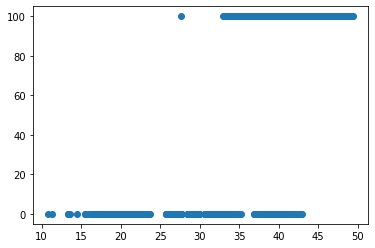

In [ ]:
# final allocation:
plt.scatter(test_meta['P_est'], test_meta['E'])